In [1]:
# Import Required Modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

%matplotlib inline

In [2]:
# Import UsArrests Dataset
usarrests_df = pd.read_csv('UsArrests.csv')
usarrests_df.head()

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [3]:
# Explore Dataset

# Dataset Summary
usarrests_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   City      50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


In [4]:
# Statistical Sumamry of Dataset
usarrests_df.describe()

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


In [5]:
# Data Shape
usarrests_df.shape

(50, 5)

# Data Pre-Analysis
This dataset containts the number of arrests per 100k capita for 50 different cities (shape[0] size) in the united states, for the crimes of Murder, Assualt, Rape as well as the percentage of the population for that city that is in an urban environment (shape[1] size) for a total of 5 fields. The dataset is based on available statistics from the year 1973. 

The categorical city column, rate per crime and urban demographic rating are in their correct data types already. 

URL: https://www.rdocumentation.org/packages/datasets/versions/3.6.2/topics/USArrests

From the above statistical summary, assualt-related crimes have the highest mean, as well as the largest standard deviation and thus variance - greatly exceeding those of the other two crime categories and the urban demographic. Thus it is key that this data is scaled to prevent such disproportionate variance from impacting the the analysis, with respect to the other variables. 

In [6]:
# Check for missing Values
missing_data = usarrests_df.isnull().sum()
field_specific_missing = pd.DataFrame(missing_data, columns=['Missing Entries'])
field_specific_missing

,Missing Entries
City,0
Murder,0
Assault,0
UrbanPop,0
Rape,0


# Missing Data
There are no missing data points for the 50 cities and their repsective crime and urban demographic scores. 

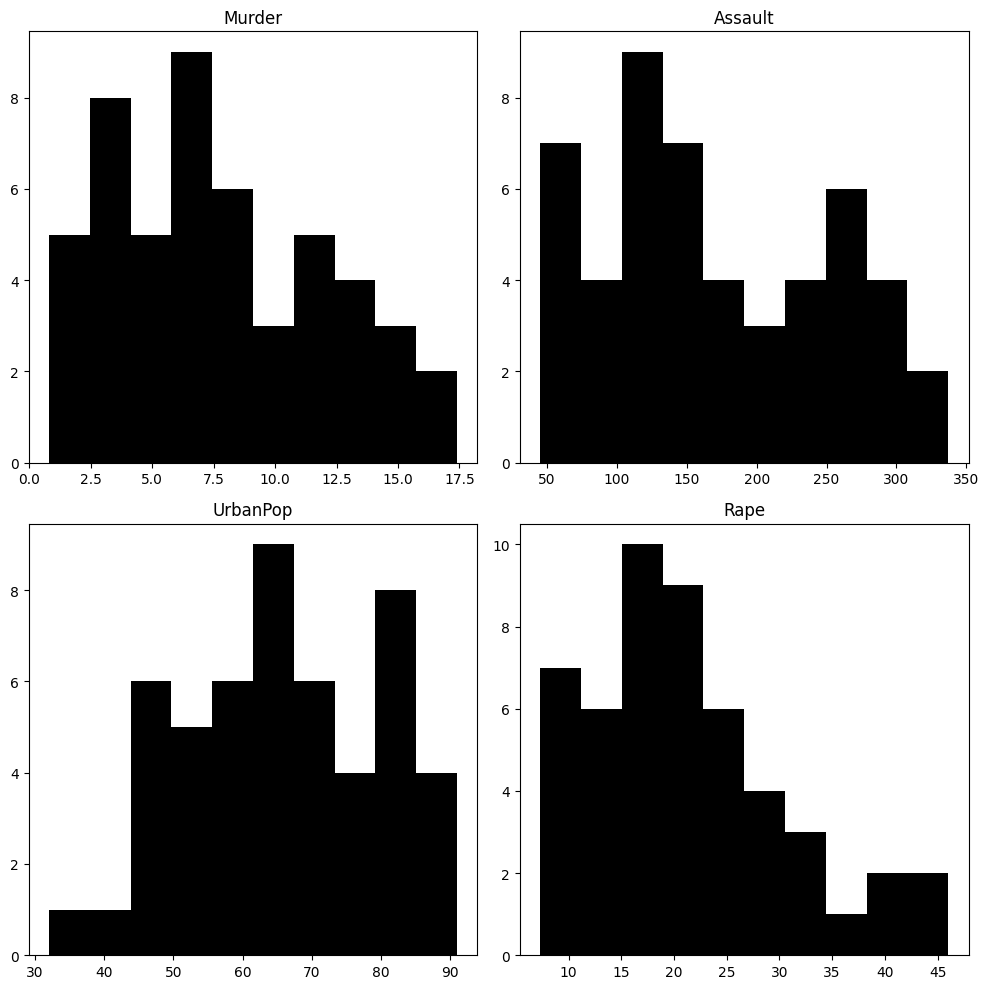

In [7]:
# Plotting of Histrograms for Numerical Categories
hists = usarrests_df.hist(color='black', grid=False, figsize=(10,10))
plt.tight_layout()
plt.show()

With the exception of the urban population metric, the crime rate statistics seem to be skewed to the data in terms of the distribution of the data and as noted by the longitudinal scales and not previously, the data will need to be scaled so as to prevent any unwanted bias from larger ranges for particular variables.

In [8]:
# Correlation Analysis
corr_df = usarrests_df.drop(['City'], axis=1).corr()
labels = corr_df.columns
correlation = corr_df.corr()

<Axes: >

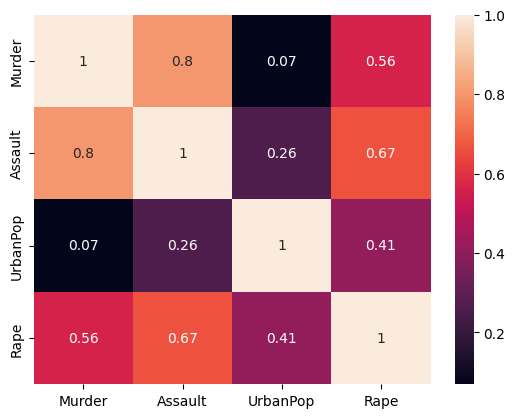

In [9]:
sns.heatmap(corr_df, annot=True)

Based on the above correlation heatmap, there is a strong positive correlation between the assualt and murder categories (near 0.8), assualt and rape (near 0.7), as well as murder and rape (near 0.6). These categories of crimes all involve violence as a main subject. Assault cases are preemptive starts to murder cases, in the event that actions are taken too far and one or both of the parties is killed in the process.

Interestingly, there are only meaningful positive correlations between the urban population metric and the crimes of rape and assualt, while there is seemingy no/little correlation with the crime of murder. This suggests that more densely populated cities don't necessitate higher murder rates, possibly due to the risk of more witnesses to the crime or higher security/police and surveilance presence. 

As there are strongly correlated variables, the dataset here is a candidate for PCA analysis to reduce the dimensionality of this study by extracting key insights from the data, while reducing the impact that more predominant variables have on the dataset as a whole that could possibly mask some key insights. 

In [10]:
# Scale the Data

# Select Only Numerical Data
numeric_data = (usarrests_df.drop(['City'], axis=1)).copy()
std_scaler = StandardScaler()

scaled_numerical_data = std_scaler.fit_transform(numeric_data)

In [11]:
# PCA Application
num_comps = 4
pca = PCA(n_components=num_comps)
prin_comps = pca.fit_transform(scaled_numerical_data)

In [13]:
# Create Dataframe of PCA Data
pca_df = pd.DataFrame(prin_comps[:,0:3], index=usarrests_df['City'])
pca_df.head()

,0,1,2
City,,,
Alabama,0.985566,1.133392,-0.444269
Alaska,1.950138,1.073213,2.040003
Arizona,1.763164,-0.745957,0.054781
Arkansas,-0.141420,1.119797,0.114574
California,2.523980,-1.542934,0.598557


<Axes: >

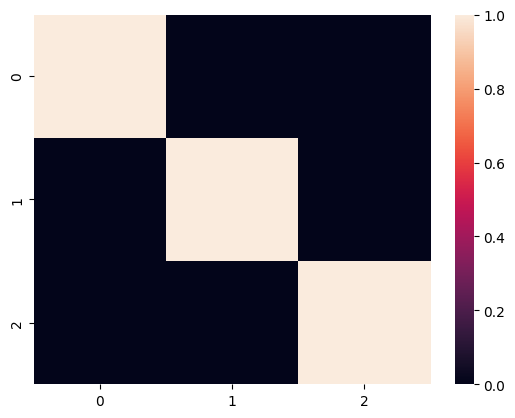

In [16]:
# Recheck Correlations
plt.figure()
sns.heatmap(pca_df.corr())

On the basis of the above correlation heatmap, there are no correlations between the PCA components as expected.

In [17]:
# Standard Deviation
std_dev = pca_df.describe().transpose()['std']
print('\nThe standard deviations of the transformed data are as follows: \n {}'.format(std_dev))


The standard deviations of the transformed data are as follows: 
 0    1.590867
1    1.004970
2    0.603191
Name: std, dtype: float64


In [18]:
# Explained Variance Proportion
var_exp = pca.explained_variance_ratio_
print('\nThe proportion of variance explained by the model is: \n {}'.format(var_exp))


The proportion of variance explained by the model is: 
 [0.62006039 0.24744129 0.0891408  0.04335752]


In [19]:
# Cumulative Explained Proportion
cum_sum = np.cumsum(pca.explained_variance_ratio_)
print('\nThe cumulative sum of the proportion of variance explained by the model is: \n {}'.format(cum_sum))


The cumulative sum of the proportion of variance explained by the model is: 
 [0.62006039 0.86750168 0.95664248 1.        ]


Text(0.5, 1.0, 'Proportion of Explained Variance for US Arrests')

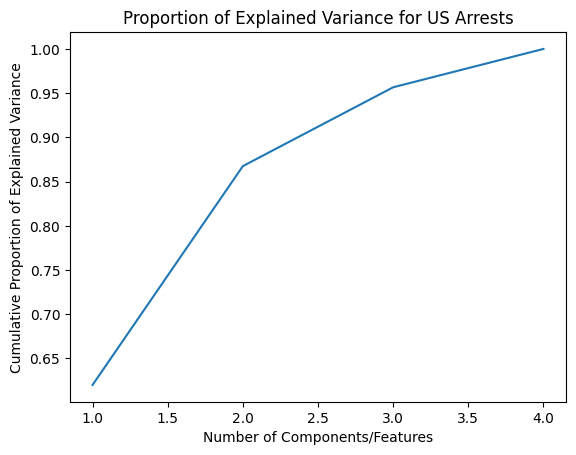

In [20]:
# Visualise Cumulative Proportion of Explained Variance and Scree Plot of the Explained Variance
# Cum Sum Graph adapted from example_plots.ipynb excercise file

plt.figure()
plt.plot(range(1,len(pca.explained_variance_ratio_)+1),np.cumsum(pca.explained_variance_ratio_))
plt.ylabel('Cumulative Proportion of Explained Variance')
plt.xlabel('Number of Components/Features')
plt.title('Proportion of Explained Variance for US Arrests')

Text(0.5, 1.0, 'Scree Plot of US Arrests')

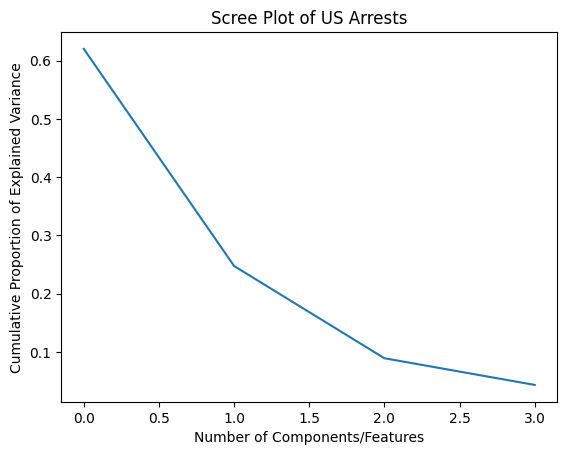

In [21]:
# Scree Plot / Explained Variance
plt.figure()
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of Components/Features')
plt.ylabel('Cumulative Proportion of Explained Variance')
plt.title('Scree Plot of US Arrests')

Only three of the four features are required to explain approximately 96% of the variability within the dataset and hence just these three features can be used in the study to follow. 

In [22]:
# Verify Feature Importance
pc1 = abs(pca.components_[0])
pc2 = abs(pca.components_[1])
# Create Feature Dataframe
feature_df = pd.DataFrame()
feature_df['Feature List'] = list(labels)
feature_df['Principle Component 1 NB'] = pc1
feature_df['Principle Component 2 NB'] = pc2
feature_df

,Feature List,Principle Component 1 NB,Principle Component 2 NB
0,Murder,0.535899,0.418181
1,Assault,0.583184,0.187986
2,UrbanPop,0.278191,0.872806
3,Rape,0.543432,0.167319


On the basis of the above dataframe, the most important first principle component is that of the Assault related crimes per 100k capita at approximately 0.58, followed closely by Rape and Murder-related case features. The urban population statistic is the most important second principle component at 0.87, greatly exceeding the closest score of approximately 0.42 for the Murder rate feature. 

In [23]:
# Hierarchical Clustering
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(pca_df)

Text(0, 0.5, 'Distance Measure')

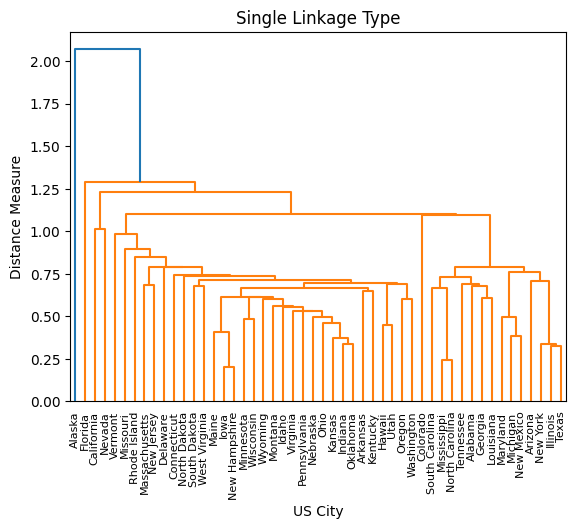

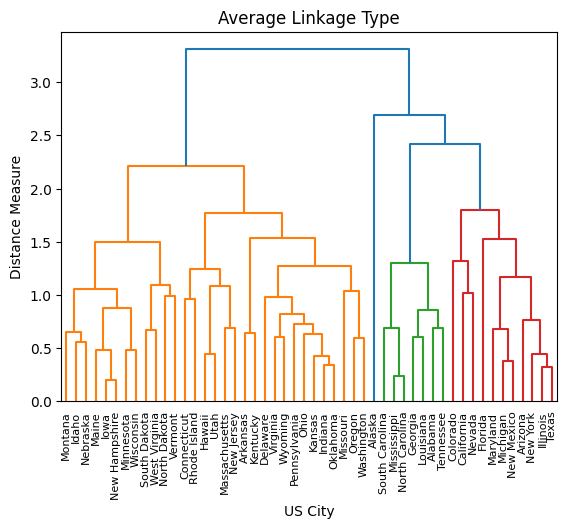

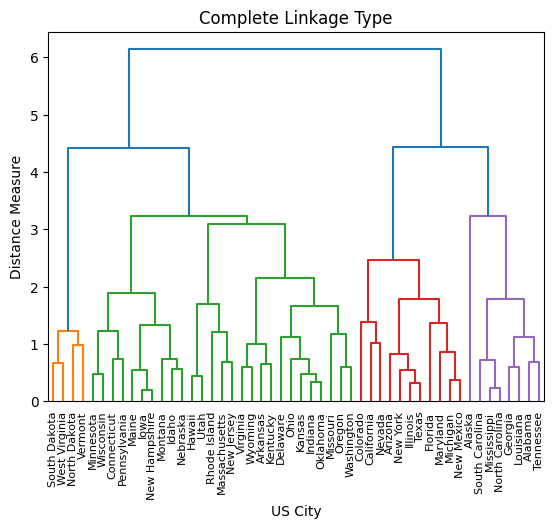

In [24]:
# Print out Dendograms
# Single Linkage 
plt.figure()
plt.title('Single Linkage Type')
dendrogram(linkage(pca_df, method='single'), labels=pca_df.index)
plt.xlabel('US City')
plt.ylabel('Distance Measure')

# Average Linkage
plt.figure()
plt.title('Average Linkage Type')
dendrogram(linkage(pca_df, method='average'), labels=pca_df.index)
plt.xlabel('US City')
plt.ylabel('Distance Measure')

# Complete Linkage
plt.figure()
plt.title('Complete Linkage Type')
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index)
plt.xlabel('US City')
plt.ylabel('Distance Measure')

The complete linkage type dendogram above highlights that two clusters can summarise the transformed dataset of three features. 

In [25]:
# Selection of Number of Clusters for KMeans Clustering
n_clusters = 2
random_state = 42

# KMeans
kmeans_model = KMeans(n_clusters=n_clusters, init='k-means++', random_state=random_state)
pca_df['Cluster Number'] = kmeans_model.fit_predict(pca_df)

In [26]:
# Number of Records in Each Cluster
pd.Series(kmeans_model.labels_).value_counts()

0    30
1    20
Name: count, dtype: int64

In [27]:
# Silhoette Score
from sklearn.metrics import silhouette_score
silhouette_score(pca_df, kmeans_model.labels_, metric='euclidean')

0.4612299607334197

The silhoette score using a Euclidean distance metric and two clustes is approxiately 0.46. 

C:\Users\jkt20\AppData\Local\Temp\ipykernel_36444\3514786333.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(pca_df[0][index], pca_df[1][index], city)


Text(0, 0.5, 'Dimension 2 / PCA 2')

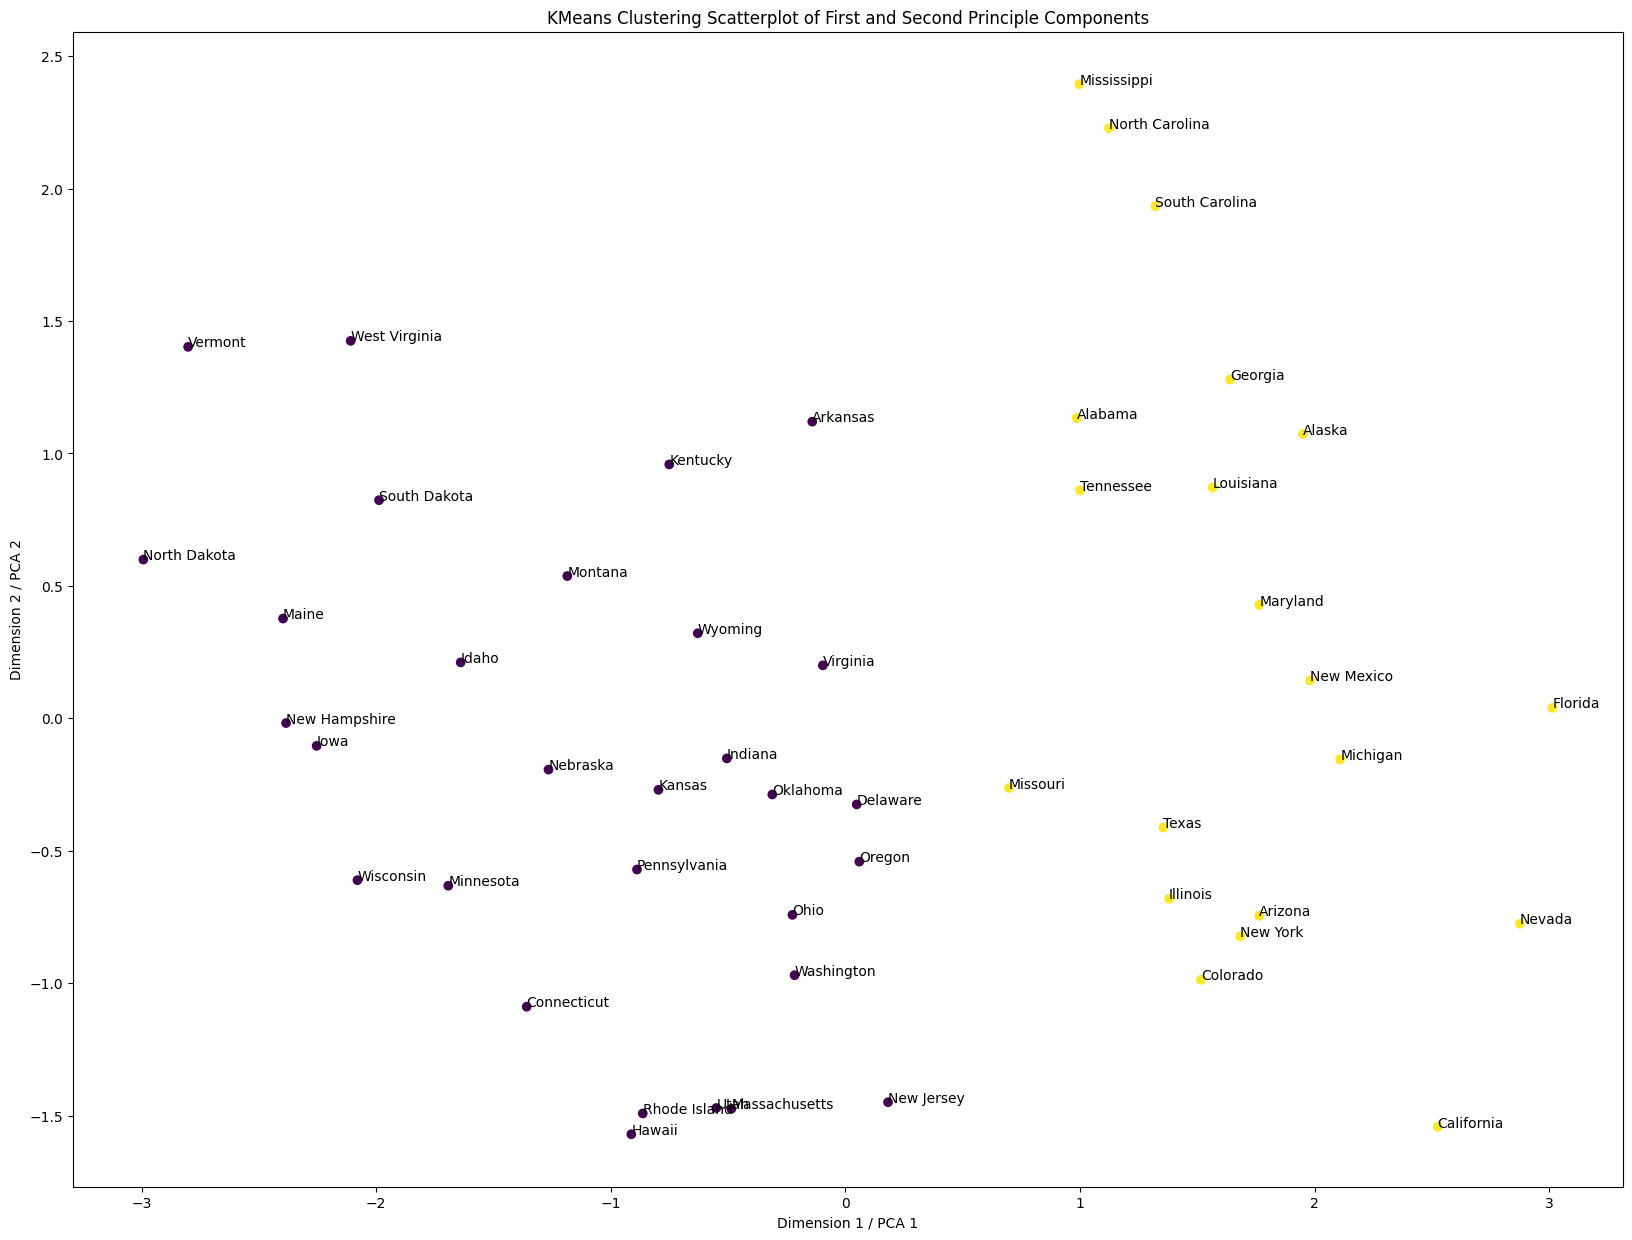

In [28]:
# Visualise Clustes on Scatterplot
plt.figure(figsize=(20,15))
plt.scatter(pca_df[0], pca_df[1], c=pca_df['Cluster Number'])
for index, city in enumerate(pca_df.index):
    plt.text(pca_df[0][index], pca_df[1][index], city)
plt.title('KMeans Clustering Scatterplot of First and Second Principle Components')
plt.xlabel('Dimension 1 / PCA 1')
plt.ylabel('Dimension 2 / PCA 2')


Based on the above scatterplot of the first two principle components, the dendrogram further above and the scatter plots below, we can make a number of observations:
* The most dangerous cities are contained within cluster number 1, as evident by the murder, assualt and rape boxplots below that show the cluster 1 group to have a higher median rate per 100k capita for all three categories of crimes. Subsequently, the cities in cluster 1 also have the highest urban populations, which is intuitive as crime rates would be higher in more congested city centres, as opposed to less densely populated urban areas with more predominant rural settings. Although the medians are within range of each other, the tail end of cluster 0 is much lower than that of cluster 1 and hence more rural-dominant cities are contained within cluster 0. 
* Alabama, Alaska and Arizona are contained with cluster number 1, pertaining to the yellow datapoints above and based on the murder boxplot below, these are high risk cities, compared to Arkansas and Conneticut in cluster 0 that are lower risk cities.
* On the Dendrogram, Alabama and Alaska are also contained within the same initial cluster grouping which aligns to the KMeans clustering scatterplot above. 
* Both clustering techniques have there assigned the various cities to clusters of high and more moderate/lower crime risks on the basis of the three crime statistics presented in the dataset. 


In [56]:
pca_new_df = pca_df.copy()
pca_new_df.reset_index(drop=True, inplace=True)
pca_new_df.head()

,0,1,2,Cluster Number
0,0.985566,1.133392,-0.444269,1
1,1.950138,1.073213,2.040003,1
2,1.763164,-0.745957,0.054781,1
3,-0.141420,1.119797,0.114574,0
4,2.523980,-1.542934,0.598557,1


In [57]:
usarrests_new_df = usarrests_df.copy()
usarrests_new_df['Cluster Number'] = pca_new_df['Cluster Number']
usarrests_new_df.head()

,City,Murder,Assault,UrbanPop,Rape,Cluster Number
0,Alabama,13.2,236,58,21.2,1
1,Alaska,10.0,263,48,44.5,1
2,Arizona,8.1,294,80,31.0,1
3,Arkansas,8.8,190,50,19.5,0
4,California,9.0,276,91,40.6,1


<Axes: xlabel='Cluster Number', ylabel='UrbanPop'>

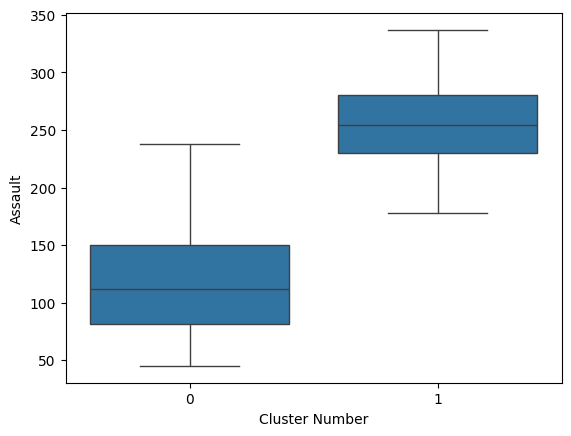

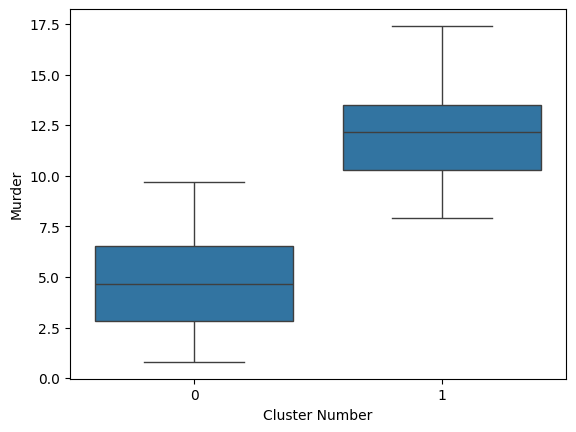

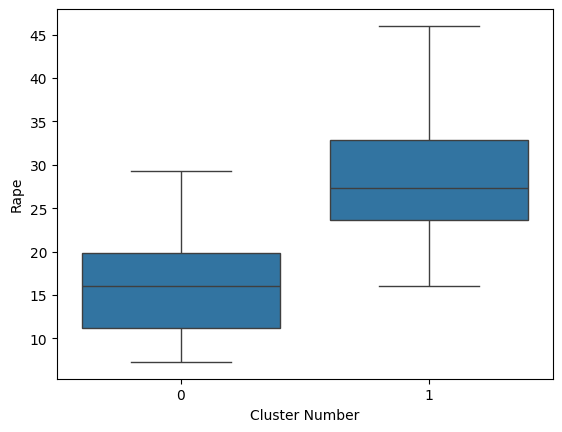

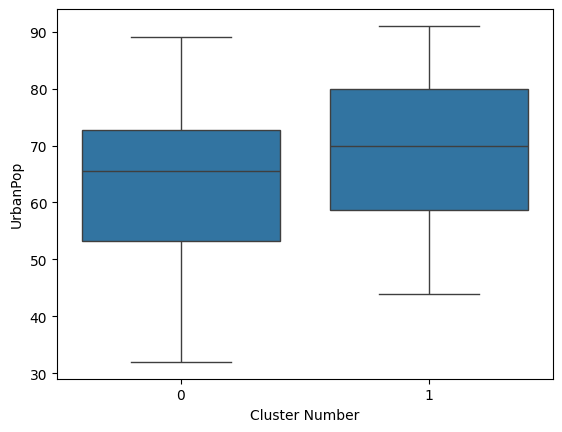

In [60]:
# Assault Boxplot
plt.figure()
sns.boxplot(x='Cluster Number', y='Assault', data = usarrests_new_df)

# Murder Boxplot
plt.figure()
sns.boxplot(x='Cluster Number', y='Murder', data = usarrests_new_df)

# Rape Boxplot
plt.figure()
sns.boxplot(x='Cluster Number', y='Rape', data = usarrests_new_df)

# Urban Population
plt.figure()
sns.boxplot(x='Cluster Number', y='UrbanPop', data = usarrests_new_df)